# Optimising a Credit Risk Strategy
---
**Scenario**: I am a Quantitative Analyst at ZNB bank. I have been with provided historical credit application data and must recommend a new strategy that expands approvals of credit card applications while keeping portfolio risk within tolerance.

My job is to find the balance between:
- Growing the number of approved customers (volume).
- Keeping overall credit losses (bad debt) under control.

Receving the data in a flat pdf, I converted the data into a csv file to get started. 

---

![Original brief table](/ard_table.png)



---
## Build a model to review strategies

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# read in data as a dataframe
asd_df = pd.read_csv("task_data.csv")
asd_df.head()

,Credit score,Applications percent,Approval rate,Default rate 6m
0,750 or more,20.0%,95.0%,0.5%
1,700 to 749,30.0%,85.0%,1.5%
2,650 to 699,25.0%,60.0%,3.0%
3,600 to 649,15.0%,30.0%,5.5%
4,Less than 600,10.0%,10.0%,12.0%


In [17]:
# convert spreadsheet values from strings to floats data types
newfloats = ['Applications percent', 'Approval rate', 'Default rate 6m']
for col in newfloats:
    asd_df[col] = asd_df[col].str.rstrip('%').astype(float) / 100

# truncate columns for ease / base columns for new model
asd_df.rename(columns={
    'Credit score': 'csbands',
    'Applications percent': 'applic',
    'Approval rate': 'approv',
    'Default rate 6m': 'default'
}, inplace=True)

# check above 
asd_df.dtypes

csbands     object
applic     float64
approv     float64
default    float64
dtype: object

In [18]:
# convert credit score bands into min and max values for modeling
asd_df["score_min"] = [750, 700, 650, 600, 0]
asd_df["score_max"] = [999, 749, 699, 649, 599]

# re-order columns with above added
asd_df = asd_df[['csbands', 'score_min','score_max', 'applic', 'approv', 'default']]
asd_df.head()

,csbands,score_min,score_max,applic,approv,default
0,750 or more,750,999,0.20,0.95,0.005
1,700 to 749,700,749,0.30,0.85,0.015
2,650 to 699,650,699,0.25,0.60,0.030
3,600 to 649,600,649,0.15,0.30,0.055
4,Less than 600,0,599,0.10,0.10,0.120


In [19]:
# build a function that calculates credit strategy metrics based on a cut-off score
def portfolio_metrics(df, cutoff=675, stress_multiplier=1.0,
                      credit_limit=5000, utilisation=0.4,
                      apr=0.20, lgd=0.90, total_applicants=100):
    """
    Parameters:
    - df: clean dataframe to populate
    - cutoff: score threshold for approvals
    - stress_multiplier: 1.0 being normal economic conditions
    - credit_limit: max credit per card
    - utilisation: average credit used, so 0.4 means 40% of limit is used
    - apr: annual revenue rate on utilised balance (fees, interest)
    - lgd: loss given default (portion of debt the bank actually loses on default)
    - total_applicants: base number of applicants to scale volume (per-100 logic)

    Returns:
    - data: band-level calculations (approvals, defaults, revenue, loss)
    - summary: portfolio-level totals and risk metrics
    """

    #make a fresh copy to keep original data intact
    data = df.copy()

    # calculate what proportion of each band gets included
    # if cutoff is lower than the band's min, include entire band (1.0)
    # if cutoff is higher than the band's max, include nothing (0.0)
    # if cutoff splits the band, include partial share
    def inclusion_share(row):
        min_score = row["score_min"]
        max_score = row["score_max"]
        if cutoff <= min_score:
            return 1.0  # full band included
        elif cutoff > max_score:
            return 0.0  # no part of band included
        else:
            # partial band: include upper part only
            included_range = max_score - cutoff
            total_range = max_score - min_score
            return included_range / total_range  # e.g. 25/50 = 0.5

    # apply the function across all bands
    data["included_share"] = data.apply(inclusion_share, axis=1)

    # estimate number of applicants per band
    # total applicants × % in this band × share included
    data["applicants"] = data["applic"] * total_applicants * data["included_share"]

    # calculate how many get approved in each band
    data["approvals"] = data["applicants"] * data["approv"]

    # estimate number of defaults
    # apply stress multiplier (1.5 = 50% more defaults in a downturn)
    data["defaults"] = data["approvals"] * data["default"] * stress_multiplier

    # calculate revenue and loss per band
    # revenue = approvals × limit × utilisation × APR
    unit_revenue = credit_limit * utilisation * apr
    # loss = defaults × limit × utilisation × LGD
    unit_loss = credit_limit * utilisation * lgd

    data["revenue"] = data["approvals"] * unit_revenue
    data["loss"] = data["defaults"] * unit_loss

    # calculate portfolio totals
    total_approvals = data["approvals"].sum()
    total_defaults = data["defaults"].sum()
    portfolio_bad_rate = (total_defaults / total_approvals * 100) if total_approvals > 0 else None

    # package the results
    summary = {
        "Approvals": total_approvals,
        "Defaults": total_defaults,
        "Portfolio Bad Rate %": portfolio_bad_rate,
        "Revenue": data["revenue"].sum(),
        "Loss": data["loss"].sum(),
        "Net Profit": data["revenue"].sum() - data["loss"].sum()
    }

    return data, summary


In [20]:
# run the portfolio_metrics function using your current dataframe (asd_df)
# and chosen cutoff score (e.g., 695 in this case).
band_results, portfolio_summary = portfolio_metrics(asd_df, cutoff=675)

# view defaults by score band
print("Band-level Results:")
print(band_results)

# call out the portfolio-level default rate from the summary dictionary
portfolio_default_rate = portfolio_summary["Portfolio Bad Rate %"]

# display the result, rounded to 2 decimal places
print(f"\nPortfolio Default Rate: {portfolio_default_rate:.2f}%")


Band-level Results:
         csbands  score_min  score_max  ...  defaults      revenue        loss
0    750 or more        750        999  ...  0.095000   7600.00000  171.000000
1     700 to 749        700        749  ...  0.382500  10200.00000  688.500000
2     650 to 699        650        699  ...  0.220408   2938.77551  396.734694
3     600 to 649        600        649  ...  0.000000      0.00000    0.000000
4  Less than 600          0        599  ...  0.000000      0.00000    0.000000

[5 rows x 12 columns]

Portfolio Default Rate: 1.35%


---

## Visualising potential strategy & safety margin

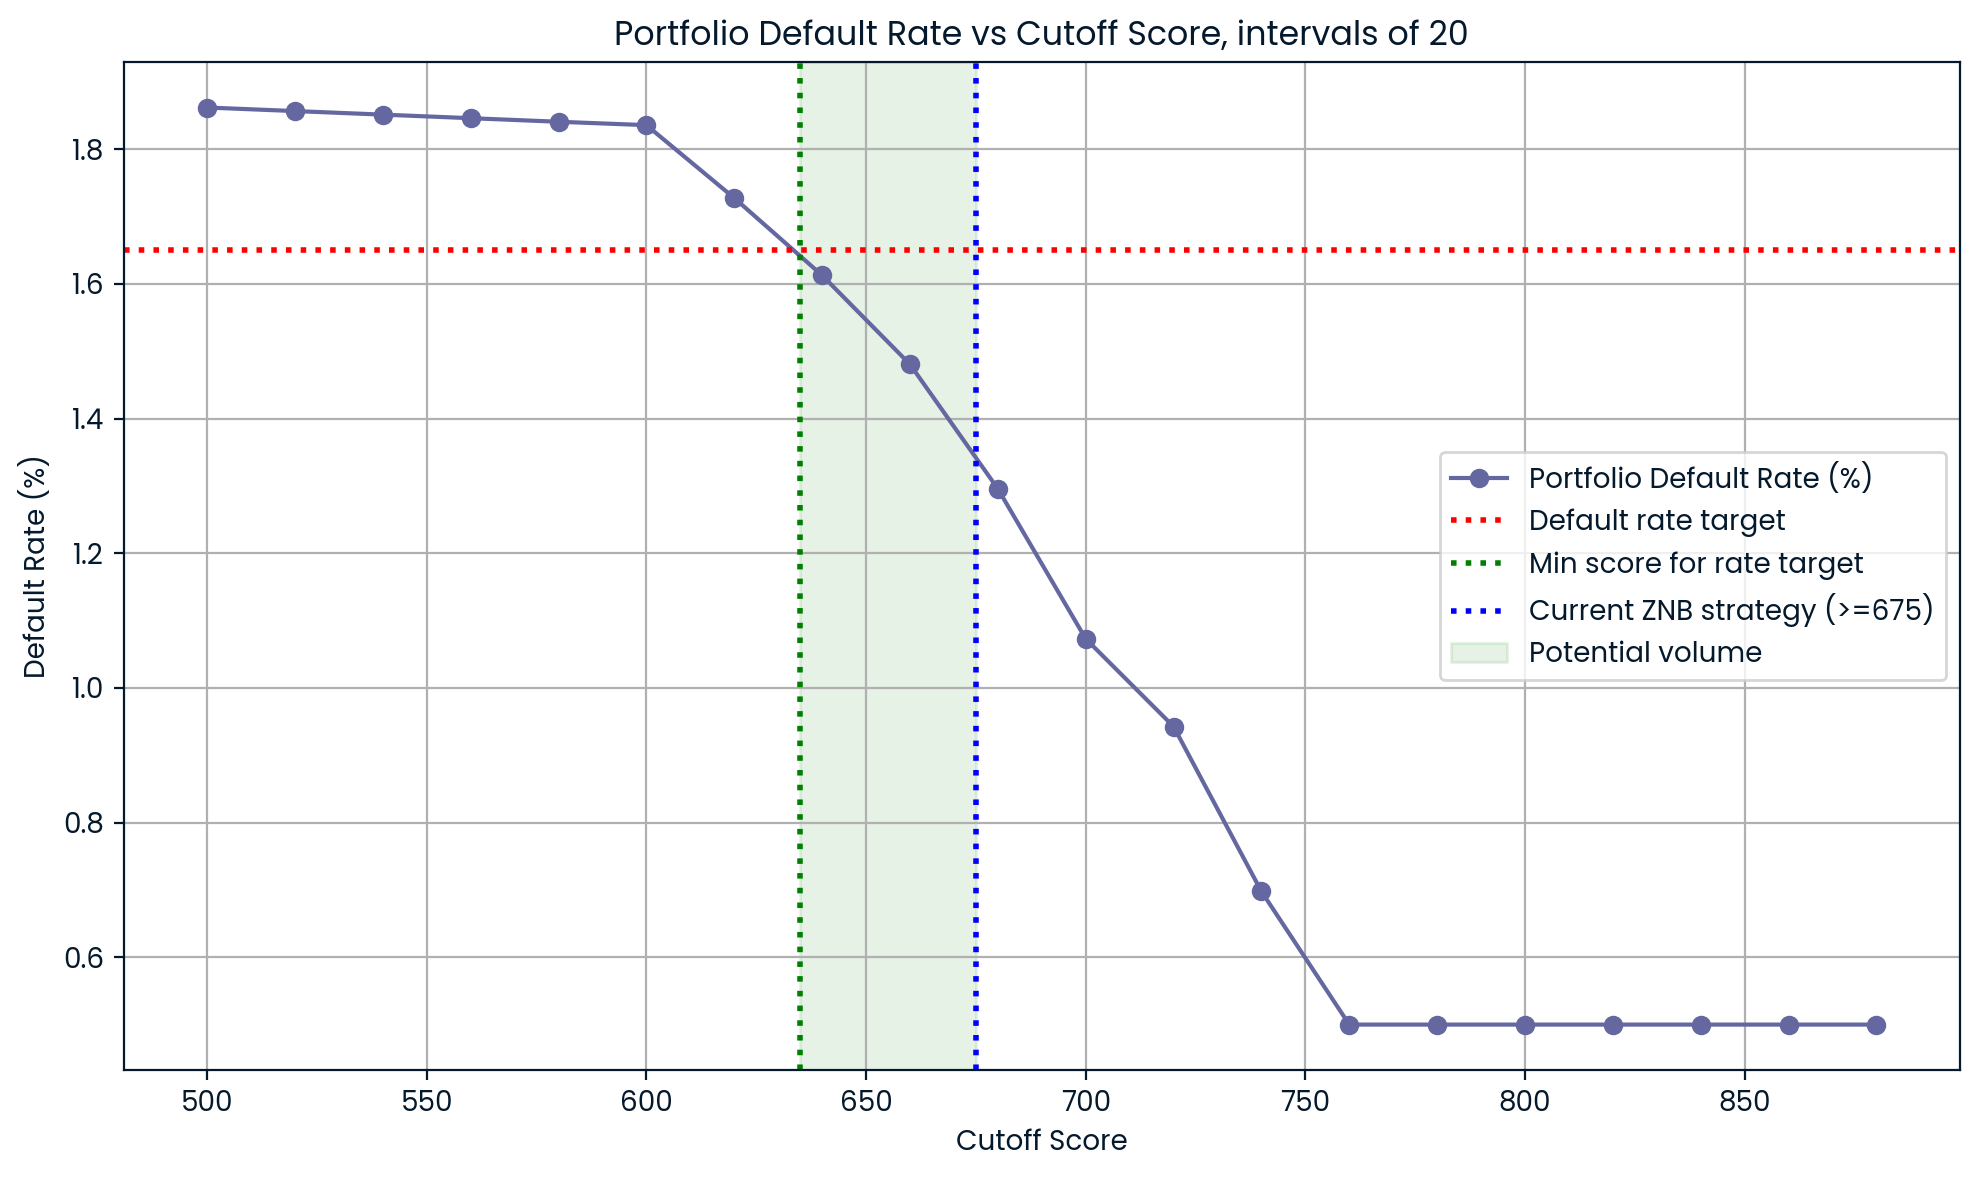

In [21]:
# define score range and increment (20 points)
cutoff_scores = range(500, 900, 20)

# create empty lists to collect metrics during loop
bad_rates = []
revenues = []
losses = []

# loop through each cutoff score and store the outputs
for cutoff in cutoff_scores:
    _, summary = portfolio_metrics(asd_df, cutoff=cutoff)
    
    # append each metric to its respective list
    bad_rates.append(summary["Portfolio Bad Rate %"])
    revenues.append(summary["Revenue"])
    losses.append(summary["Loss"])

# visualise above, adding custom markers for current & potential strategy
plt.figure(figsize=(10, 6))
plt.plot(cutoff_scores, bad_rates, marker='o', label='Portfolio Default Rate (%)')
plt.title('Portfolio Default Rate vs Cutoff Score, intervals of 20')
plt.xlabel('Cutoff Score')
plt.ylabel('Default Rate (%)')
plt.axhline(1.65, color='red', linestyle=':', linewidth=2, label='Default rate target')
plt.axvline(635, color='green', linestyle=':', linewidth=2, label='Min score for rate target')
plt.axvline(675, color='blue', linestyle=':', linewidth=2, label='Current ZNB strategy (>=675)')
plt.axvspan(635, 675, color='green', alpha=0.1, label='Potential volume')
plt.grid(True)
plt.legend(loc='right')
plt.tight_layout()
plt.show()

### Summary of findings:

Based on the analysis, the current ZNB strategy (cutoff ≥675) results in a portfolio default rate of 1.35%, well below the 1.65% risk target.

The model shows that we could safely lower the cutoff to 635 while still remaining within the bank’s risk appetite.

---

## Comparing strategies - current (≥ 675) vs. proposed (≥ 635)

In [22]:
# define the strategies as variables
cutoff_current = 675
cutoff_proposed = 635

# run model for the current strategy
_, current_summary = portfolio_metrics(asd_df, cutoff=cutoff_current)

# run model for the proposed strategy
_, proposed_summary = portfolio_metrics(asd_df, cutoff=cutoff_proposed)

# extract key metrics from each and build a comparison table
comparison_data = {
    "Cut-off Strategy": [f"≥ {cutoff_current}", f"≥ {cutoff_proposed}"],
    "Approvals": [current_summary["Approvals"], proposed_summary["Approvals"]],
    "Defaults": [current_summary["Defaults"], proposed_summary["Defaults"]],
    "Default Rate (%)": [current_summary["Portfolio Bad Rate %"], proposed_summary["Portfolio Bad Rate %"]],
    "Revenue ($)": [current_summary["Revenue"], proposed_summary["Revenue"]],
    "Loss ($)": [current_summary["Loss"], proposed_summary["Loss"]],
    "Net Profit ($)": [current_summary["Net Profit"], proposed_summary["Net Profit"]]
}

# create a dataframe for display
comparison_df = pd.DataFrame(comparison_data).round(2)
display(comparison_df)

# compare profit outcomes between current and proposed strategies
profit_1 = float(comparison_df["Net Profit ($)"].iloc[0])  
profit_2 = float(comparison_df["Net Profit ($)"].iloc[1])  

profit_diff = profit_2 - profit_1
percent_increase = (profit_diff / profit_1) * 100

print(f"Reducing the cut-off threshold from 675 to 635 would potentially:")
print(f"• Increase total net profit by: ${profit_diff:.2f} per 100 customers (on average)")
print(f"• This represents an approximate percentage increase of: {percent_increase:.2f}%")



,Cut-off Strategy,Approvals,Defaults,Default Rate (%),Revenue ($),Loss ($),Net Profit ($)
0,≥ 675,51.85,0.7,1.35,20738.78,1256.23,19482.54
1,≥ 635,60.79,1.0,1.64,24314.29,1796.79,22517.50


Reducing the cut-off threshold from 675 to 635 would potentially:
• Increase total net profit by: $3034.96 per 100 customers (on average)
• This represents an approximate percentage increase of: 15.58%


---

## Factoring in economic uncertainty with a stress-test

In [23]:
# stress test function 
def stress_test_row(original_summary, cutoff_label):
    
    # simulate a recession by increasing defaults and bad rate by 50%
    defaults = original_summary["Defaults"] * 1.5
    bad_rate = original_summary["Portfolio Bad Rate %"] * 1.5
    revenue = original_summary["Revenue"]
    loss = defaults * LOSS_PER_DEFAULT
    net_profit = revenue - loss

    # build and return the stress-tested row
    return pd.Series([
        cutoff_label,
        original_summary["Approvals"],
        defaults,
        bad_rate,
        revenue,
        loss,
        net_profit
    ], index=[
        "Strategy",
        "Approvals",
        "Defaults",
        "Default Rate (%)",
        "Revenue ($)",
        "Loss ($)",
        "Net Profit ($)"
    ])

# generate recession rows from original summaries 
recession_row_675 = stress_test_row(current_summary, "Cutoff ≥675 (Mild Recession)")
recession_row_635 = stress_test_row(proposed_summary, "Cutoff ≥635 (Mild Recession)")

# combine them into a df
recession_df = pd.DataFrame([recession_row_675, recession_row_635])

# append to existing comparison table
comparison_df = pd.concat([comparison_df, recession_df], ignore_index=True)

# ensure all values are float for plotting
comparison_df["Net Profit ($)"] = comparison_df["Net Profit ($)"].astype(float)


---

## Visualising the slope between strategies with the recession factor

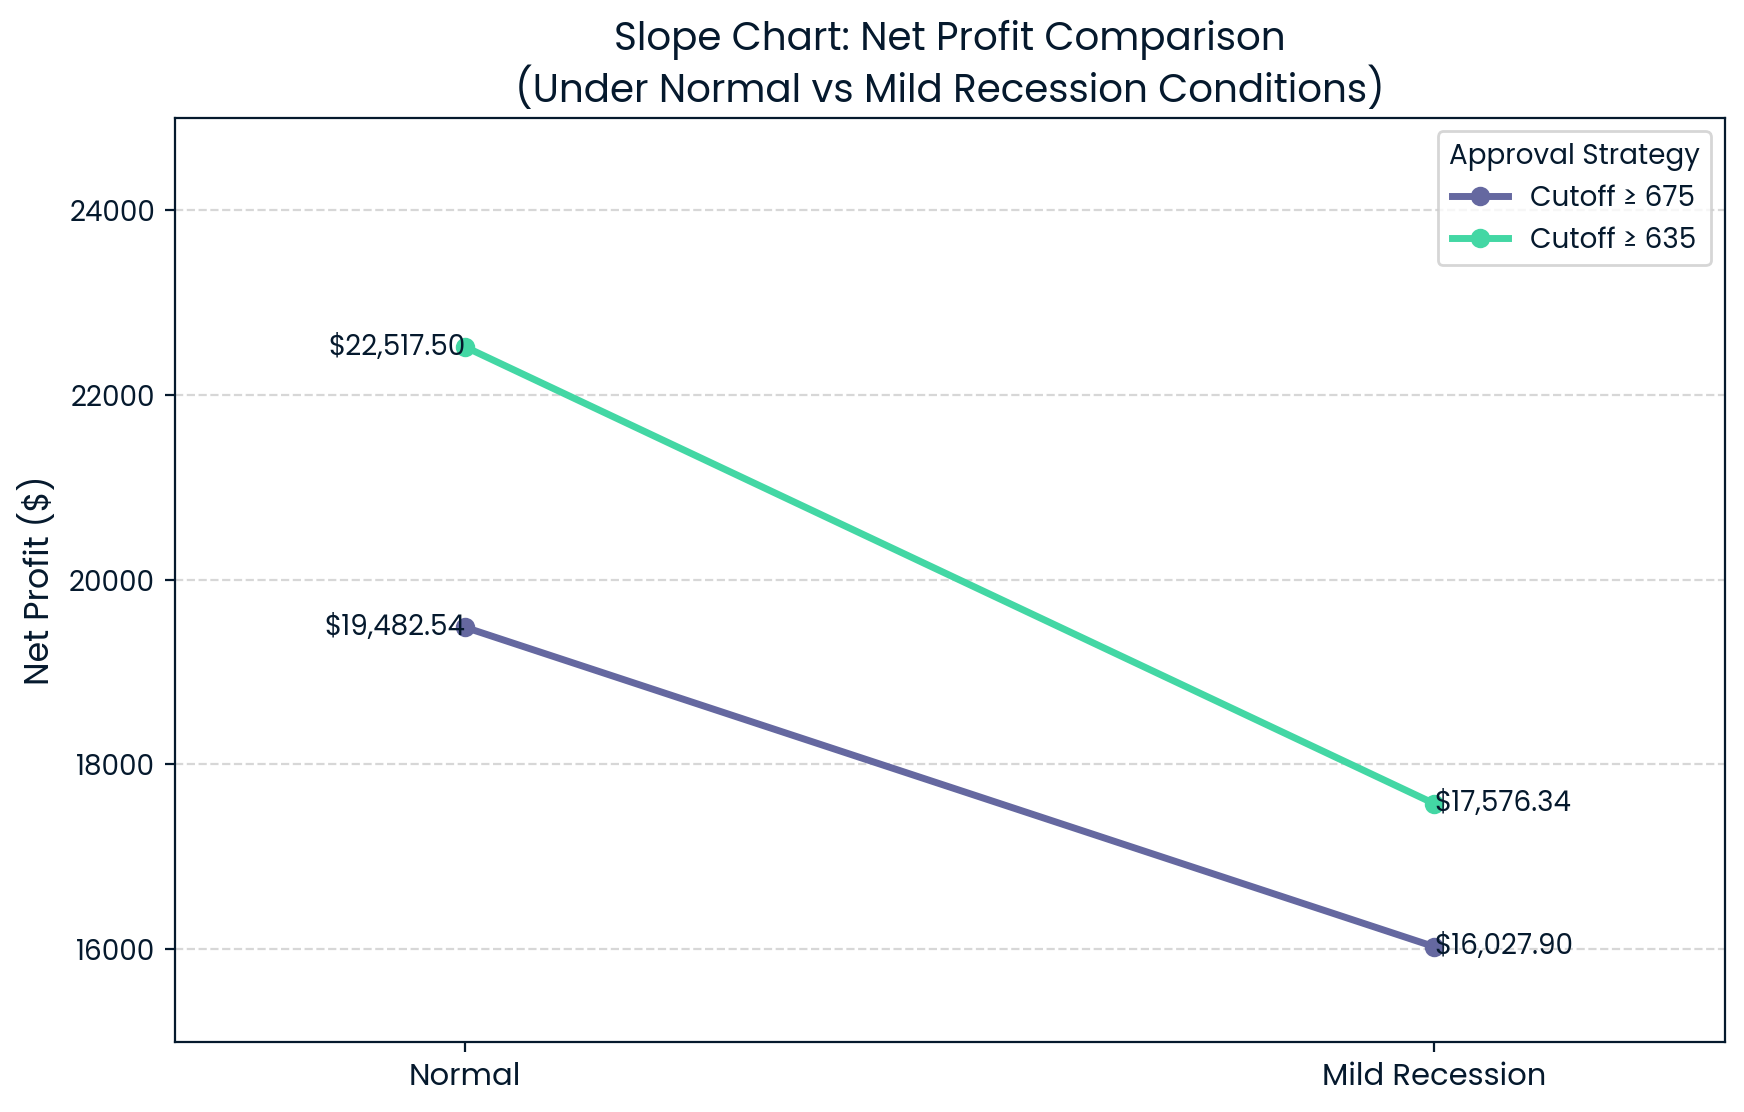

In [24]:

# define strategies and profits 
strategies = ['Cutoff ≥ 675', 'Cutoff ≥ 635']
normal_profits = [19482.54, 22517.50]
recession_profits = [16027.90, 17576.34]

# set up the figure and axis 
plt.figure(figsize=(10, 6))

# plot lines for each strategy
for i in range(len(strategies)):
    x = [0, 1]  # 0 normal, 1 recession
    y = [normal_profits[i], recession_profits[i]]

    plt.plot(x, y, marker='o', label=strategies[i], linewidth=2.5)
    plt.text(0, y[0], f"${y[0]:,.2f}", va='center', ha='right', fontsize=10)
    plt.text(1, y[1], f"${y[1]:,.2f}", va='center', ha='left', fontsize=10)

# customisations to chart
plt.xticks([0, 1], ['Normal', 'Mild Recession'], fontsize=11)
plt.ylabel("Net Profit ($)", fontsize=12)
plt.title("Slope Chart: Net Profit Comparison\n(Under Normal vs Mild Recession Conditions)", fontsize=14)
plt.xlim(-0.3, 1.3)
plt.ylim(15000, 25000) 
plt.legend(title="Approval Strategy")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


## Summary Insights
- Under normal conditions, the 635 strategy yields **~15.6% more net profit**
- Even in a mild recession (50% more defaults), the gain remains positive at **~9.7%**
- This suggests the 635 strategy is resilient under stress and worth considering


In [25]:
# calculate % increase for normal_profits
normal_pct_increase = ((normal_profits[1] - normal_profits[0]) / normal_profits[0]) * 100

# calculate % increase for recession_profits
recession_pct_increase = ((recession_profits[1] - recession_profits[0]) / recession_profits[0]) * 100

# % difference
difference = normal_pct_increase - recession_pct_increase

print("-- POTENTIAL STRATEGY OUTPUT ------------")
print(f"Normal profits % increase: {normal_pct_increase:.2f}%")
print(f"Recession profits % increase: {recession_pct_increase:.2f}%")

-- POTENTIAL STRATEGY OUTPUT ------------
Normal profits % increase: 15.58%
Recession profits % increase: 9.66%


## Final Summary

Lowering the cutoff score from **675 to 635** offers a strong uplift in approved volume and net profit, while still keeping portfolio-level risk below the 1.65% threshold.

Even in a stress scenario with 50% more defaults:
- Profit impact remains positive
- The strategy remains within acceptable risk limits

#### Analyst's recommendation

Adopt the 635 cutoff to increase reach and profitability without compromising the bank’s risk tolerance.
